### Дипломная работа Александра Соколова

#### Разведывательный анализ данных (EDA)
Кернел 1 из 5 в разделе ML (отредактирован 21.04.2021)
---

# 1. Импорт библиотек, инициализация глобальных констант
## 1.1. Импорт библиотек

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pandas_profiling
import tqdm

import os
import gc

pd.set_option('display.max_columns', None)

In [2]:
import utils_21042021 as utils

## 1.2. Глобальные константы

In [3]:
# CURRENT_DIR = './'  # имя текущей директории для локальной машины 
CURRENT_DIR = '../'  # имя текущей директории для каггл

PATH_TO_WORKDIR = CURRENT_DIR + 'working/'

PATH_TO_TRAIN_TARGET = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_train_target.csv'
PATH_TO_TEST_TARGET = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_TRAIN = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest'
PATH_TO_TEST = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'


In [4]:
!pip freeze > requirements.txt

# 2. Вспомогательные функции

In [5]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_pirtition)
    for path_to_parquet in tqdm.tqdm_notebook(list_path_to_partitions, 
                                              desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

# 3. EDA
---
## 3.1 product

In [6]:
train_targets = pd.read_csv(PATH_TO_TRAIN_TARGET)
train_targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [7]:
pandas_profiling.ProfileReport(train_targets)

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В трейне 963811 объектов. 5 видов банковских продуктов. flag бинарный. Пропусков нет.

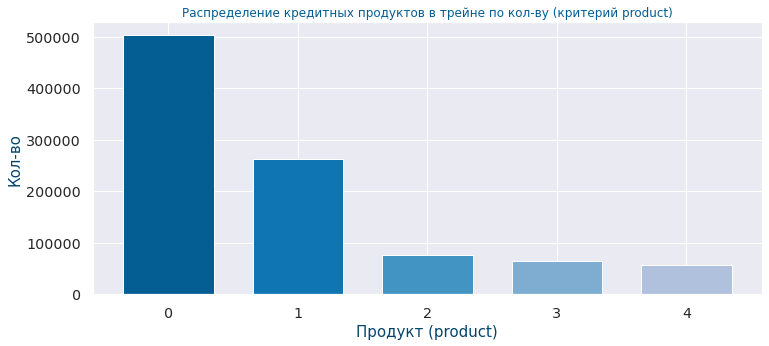

In [8]:
utils.simple_plot_barv_count('Распределение кредитных продуктов в трейне по кол-ву', 
                             'product', 
                             train_targets, 
                             1.3, 
                             'Продукт (product)', 
                             'Кол-во')

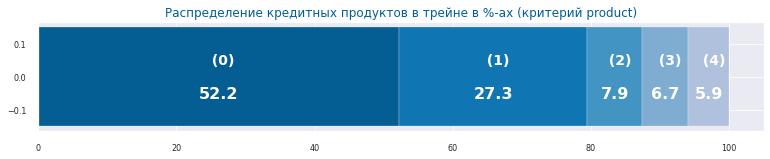

In [9]:
utils.simple_plot_barh_procent('Распределение кредитных продуктов в трейне в %-ах', 
                               ['','','','',''], 
                               'product',
                               train_targets)

In [10]:
temp_df = pd.DataFrame(train_targets['product'].value_counts())
temp_df = temp_df.rename(columns={'product': 'product_count'})
temp_df['product'] = temp_df.index
temp_df['flag'] = train_targets.groupby('product').sum().flag
temp_df['proc_default'] = temp_df['flag']/temp_df['product_count']*100

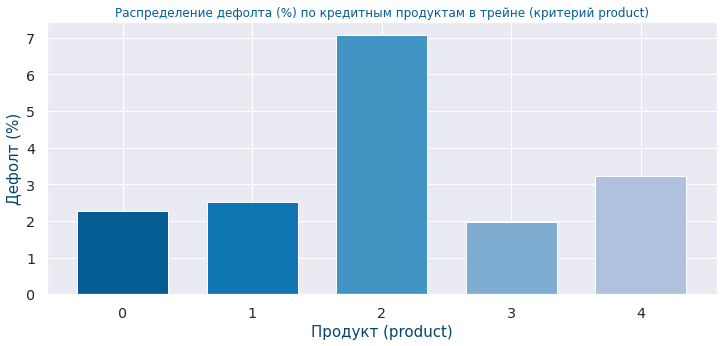

In [11]:
utils.simple_plot_barv('Распределение дефолта (%) по кредитным продуктам в трейне',
                       'product',
                       'proc_default', 
                       temp_df, 
                       1.3, 
                       'Продукт (product)', 
                       'Дефолт (%)')

In [12]:
test_targets = pd.read_csv(PATH_TO_TEST_TARGET)
test_targets.head()

,app_id,product
0,1063620,0
1,1063621,0
2,1063622,1
3,1063623,1
4,1063624,2


In [13]:
pandas_profiling.ProfileReport(test_targets)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В тесте 502716 объектов. Также 5 видов банковских продуктов. Пропусков нет.

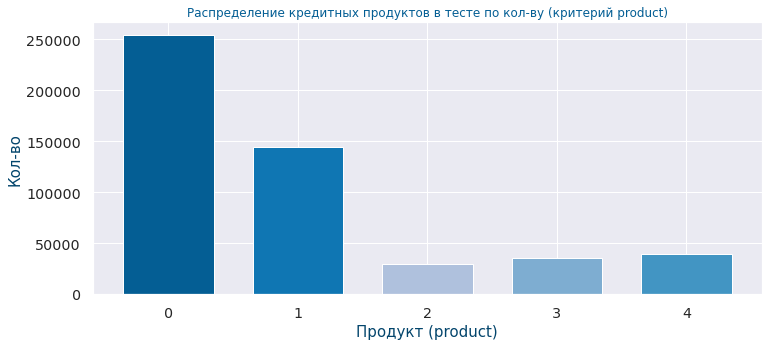

In [14]:
utils.simple_plot_barv_count('Распределение кредитных продуктов в тесте по кол-ву', 
                             'product', 
                             test_targets, 
                             1.3, 
                             'Продукт (product)', 
                             'Кол-во')

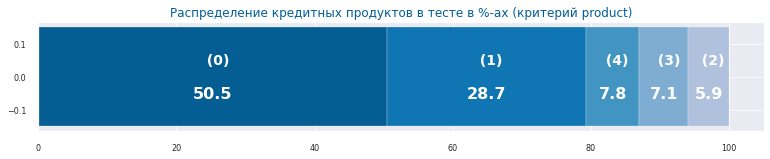

In [15]:
utils.simple_plot_barh_procent('Распределение кредитных продуктов в тесте в %-ах', 
                               ['','','','',''], 
                               'product',
                               test_targets)

Распределения признака product в трейне и тесте сбалансированы

## 3.2 Анализ необходимой памяти для выгрузки одного признака

In [16]:
%%time
temp_df = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                                     start_from=0, 
                                                     
                                                     num_parts_to_read=1,
                                                     info_num_parts=True)

memory_usage_of_frame = temp_df.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 50
print(f'Объем памяти в  RAM одной партиции данных с транзакциями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

Объем памяти в  RAM одной партиции данных с транзакциями: 0.476 Gb
Ожидаемый размер в RAM всего датасета: 23.798 Gb
CPU times: user 2.07 s, sys: 1.73 s, total: 3.8 s
Wall time: 3.33 s


In [17]:
temp_df.head(10)

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5
5,0,0.516834,1,2,98,3,1,3,7,3,2,1,37,2,4,16,337,53,0,6
6,0,0.258972,1,2,98,3,1,1,6,1,2,1,2,2,2,18,334,53,75,7
7,0,0.297589,1,2,98,3,1,1,6,1,2,1,2,2,2,19,327,52,169,8
8,0,0.356078,1,1,5,2,1,1,2,1,10,1,49,7,7,13,326,52,18,9
9,0,0.333547,1,1,5,2,1,1,2,1,10,1,49,7,7,13,326,52,0,10


In [18]:
del temp_df
gc.collect()

40

In [19]:
%%time
temp_df = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                             start_from=0, 
                                             columns = ['app_id'],
                                             num_parts_to_read=50,
                                             info_num_parts=True)

memory_usage_of_frame = temp_df.memory_usage(index=True).sum() / 10**9

print(f'Объем памяти в RAM для одного признака app_id в трейне: {round(memory_usage_of_frame, 3)} Gb')


Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/50 [00:00<?, ?it/s]

Объем памяти в RAM для одного признака app_id в трейне: 1.082 Gb
CPU times: user 14.7 s, sys: 5.43 s, total: 20.1 s
Wall time: 26.9 s


In [20]:
%%time
temp_test_df = read_parquet_dataset_from_local(PATH_TO_TEST, 
                                             start_from=0, 
                                             columns = ['app_id'],
                                             num_parts_to_read=50,
                                             info_num_parts=True)

memory_usage_of_frame = temp_test_df.memory_usage(index=True).sum() / 10**9

print(f'Объем памяти в RAM для одного признака app_id в тесте: {round(memory_usage_of_frame, 3)} Gb')

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/50 [00:00<?, ?it/s]

Объем памяти в RAM для одного признака app_id в тесте: 0.693 Gb
CPU times: user 13.6 s, sys: 7 s, total: 20.6 s
Wall time: 25.6 s


## 3.3 app_id

In [21]:
temp_df['app_id'].count()

270450065

В тренировочной выборке более 270 млн транзакций 

In [22]:
temp_test_df['app_id'].count()

173144825

В тестовой выборке более 170 млн транзакций. В сумме около 444 млн. транзакций. 

In [23]:
temp_df = pd.DataFrame(temp_df['app_id'].value_counts())
temp_df = temp_df.rename(columns={'app_id': 'app_count'})
temp_df['app_id'] = temp_df.index
temp_df = temp_df.reset_index()

temp_df.app_count.describe()

count    963811.000000
mean        280.604875
std         309.928686
min           6.000000
25%          66.000000
50%         177.000000
75%         388.000000
max        9580.000000
Name: app_count, dtype: float64

In [24]:
temp_test_df = pd.DataFrame(temp_test_df['app_id'].value_counts())
temp_test_df = temp_test_df.rename(columns={'app_id': 'app_count'})
temp_test_df['app_id'] = temp_test_df.index
temp_test_df = temp_test_df.reset_index()

temp_test_df.app_count.describe()

count    502716.000000
mean        344.418767
std         376.888170
min           6.000000
25%          79.000000
50%         216.000000
75%         482.000000
max        6751.000000
Name: app_count, dtype: float64

<AxesSubplot:title={'center':'Распределение кол-ва транзакций по объектам'}, ylabel='Кол-во транзакций'>

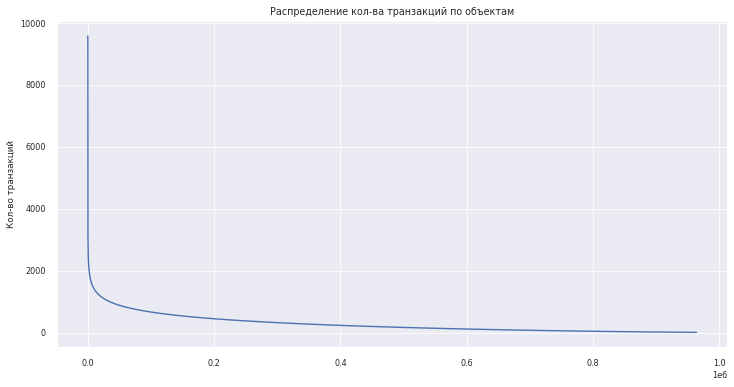

In [25]:
temp_df.app_count.plot(figsize = (12,6), 
                       title='Распределение кол-ва транзакций по объектам',
                       ylabel = 'Кол-во транзакций')

In [26]:
del temp_df
del temp_test_df
gc.collect()

37

## 3.4 amnt

In [27]:
%%time
temp_df = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                             start_from=0, 
                                             columns = ['amnt'],
                                             num_parts_to_read=50,
                                             info_num_parts=True)

memory_usage_of_frame = temp_df.memory_usage(index=True).sum() / 10**9

print(f'Объем памяти в RAM для одного признака amnt в трейне: {round(memory_usage_of_frame, 3)} Gb')


Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/50 [00:00<?, ?it/s]

Объем памяти в RAM для одного признака amnt в трейне: 2.164 Gb
CPU times: user 17.9 s, sys: 9.65 s, total: 27.6 s
Wall time: 35.3 s


In [28]:
%%time
temp_test_df = read_parquet_dataset_from_local(PATH_TO_TEST, 
                                             start_from=0, 
                                             columns = ['amnt'],
                                             num_parts_to_read=50,
                                             info_num_parts=True)

memory_usage_of_frame = temp_test_df.memory_usage(index=True).sum() / 10**9

print(f'Объем памяти в RAM для одного признака amnt в тесте: {round(memory_usage_of_frame, 3)} Gb')

Кол-во партиций в папке: 50


Читаем файлы::   0%|          | 0/50 [00:00<?, ?it/s]

Объем памяти в RAM для одного признака amnt в тесте: 1.385 Gb
CPU times: user 14 s, sys: 4.44 s, total: 18.4 s
Wall time: 24.9 s


In [29]:
temp_df.amnt.describe()

count    2.704501e+08
mean     3.588647e-01
std      9.892837e-02
min      0.000000e+00
25%      2.929345e-01
50%      3.479347e-01
75%      4.150716e-01
max      1.000000e+00
Name: amnt, dtype: float64

In [30]:
temp_test_df.amnt.describe()

count    1.731448e+08
mean     3.444327e-01
std      1.042859e-01
min      0.000000e+00
25%      2.815391e-01
50%      3.356404e-01
75%      4.007231e-01
max      9.407143e-01
Name: amnt, dtype: float64

In [31]:
len(temp_df[temp_df['amnt']==0])

1248424

In [32]:
len(temp_test_df[temp_test_df['amnt']==0])

2846900

Кол-во пропусков в трейне 1248424 (0.46%), а в тесте 2846900 (1.6%)